# Center of Mass estimator: explanation of the code

If the center_of_mass package is not installed, run the following lines:
```
import sys
sys.path.insert(0, '../src')
```

In [1]:
import center_of_mass

In [2]:
import numpy, pickle, sys

Measurement errors used for calculating the optimal estimator gains

In [3]:
Position_std = 0.0035 # standard deviation of the error in CoM position obtained from the kinematics alone (in m)
Force_std    = 2      # standard deviation of the error in Ground reaction force (in N)

The example data file is loaded

In [4]:
input_file     = '..\examples\example_data.pkl'
pickle_file    = open(input_file,'rb')
data           = pickle.load(pickle_file)
pickle_file.close()

sex                 = data['sex']                # 'female' or 'male'
Labels              = data['Labels']             # list of marker labels
Kinematic_frequency = data['Position_frequency'] # in Hertz
Position            = data['Position']           # dictionary with, for each marker, the position in meters (numpy.ndarray of shape (3,duration*Position_frequency)
Force_frequency     = data['Force_frequency']    # in Hertz
GroundReactionForce = data['GroundReactionForce']# in Newtons (numpy.ndarray of shape (3,duration*Force_frequency)

The center of mass is calculated (in this example we use the method of Dumas et al. 2007).

In [5]:
kinematics    = center_of_mass.Kinematics(Position, Labels, sex)
Kinematic_com = kinematics.calculate_CoM()

The person's mass is determined as the median vertical ground reaction force during the initial 1.5 seconds of quiet standing

In [6]:
mass = numpy.median(GroundReactionForce[2,:int(1.5*Force_frequency)])/9.81

The Center of Mass acceleration is calculated by subtracting the weight from the ground reaction force and dividing by mass. By default, the vertical axis is assumed to correspond to the third row of the Ground Reaction Force, and to be oriented upwards. However, this can be changed through the arguments 'vertical' and 'direction'.

In [7]:
def com_acceleration(GroundReactionForce, mass, gravity_direction = numpy.array([0,0,-1])):
    '''Calculates the CoM acceleration from the Ground reaction force and mass 
    
    Parameters
    ----------
    GroundReactionForce: (NbOfDimensions,NbOfSamples) numpy.ndarray
        Ground reaction force (in Newton)
    mass: float 
        subject's mass (in kg)
    gravity_direction: (NbOfDimensions) numpy.ndarray, optional
        direction of the gravity vector used to subtract the subject's weight, default is numpy.array([0,0,-1])

    Returns
    -------
    Acceleration: (NbOfDimensions,NbOfSamples) numpy.ndarray
        Acceleration of the Center of Mass (in m/s^2)
    '''
    ## The net force is the sum of the ground reaction force and the person's weight 
    NetForce = GroundReactionForce + mass*9.81*numpy.array([gravity_direction]).T
    ## Acceleration is force divided by mass
    Acceleration = NetForce/mass
    return Acceleration

In [8]:
Acceleration = com_acceleration(GroundReactionForce, mass)

The position and acceleration signals must be synchronised before applying the filtering. If they have a different sampling frequency, they are sub-sampled at a common frequency. The user can specify a desired sub-sampling frequency (which must be a common divisor of both Position_frequency and Acceleration_frequency). Otherwise, the greatest common divisor is used as the sub-sampling frequency.

In [9]:
def subsample_one_signal(signal, signal_frequency, sub_frequency):
    '''Subsample a signal at a given Frequency
    
    Parameters
    ----------
    signal: (NbOfDimensions, NbOfSamples) numpy.ndarray
        Signal to subsample
    signal_frequency: int 
        Sampling frequency (in Hertz) of the signal
    sub_frequency: int 
        Desired sub-sampling frequency (in Hertz)
        
    Returns
    -------   
    signal_subsampled: (NbOfDimensions, NbOfSamples_sub) numpy.ndarray
        Subsampled signal
    '''
    # The sub-sampling frequency must be a divisor of the signal frequency:
    if signal_frequency % sub_frequency != 0:
        raise ValueError('The sub-sampling frequency is not a divisor of the signal frequency. This would lead to synchronisation issues when sub-sampling.')
    else:
        if signal_frequency == sub_frequency:
            return signal
        else:    
            bin_size          = int(signal_frequency/sub_frequency) # the signal will be averaged over bins of this size
            NbOfDimensions    = numpy.shape(signal)[0]
            NbOfSamples_sub   = int(numpy.shape(signal)[1]/bin_size)
            signal_truncated  = signal[:,:bin_size*NbOfSamples_sub] 
            signal_subsampled = numpy.zeros((NbOfDimensions,NbOfSamples_sub))
            for dim in range(NbOfDimensions):
                signal_reshape         = signal_truncated[dim].reshape(NbOfSamples_sub,bin_size)
                signal_subsampled[dim] = numpy.mean(signal_reshape, axis = 1)   
            return signal_subsampled


def subsample_two_signals(signal1, frequency1, signal2, frequency2, sub_frequency = None):
    '''Subsample two signals at a common frequency
    
    Parameters
    ----------
    signal1: (NbOfDimensions,NbOfSamples1) numpy.ndarray
        First signal
    frequency1: int 
        Sampling frequency (in Hertz) of the first signal
    signal2: (NbOfDimensions,NbOfSamples2) numpy.ndarray
        Second signal
    frequency2: int 
        Sampling frequency (in Hertz) of the second signal
    sub_frequency: int, optional 
        Desired sub-sampling frequency (in Hertz), default is None
        
    Returns
    -------   
    signal1_subsampled: (NbOfDimensions,NbOfSamples_sub) numpy.ndarray
        Subsampled first signal
    signal2_subsampled: (NbOfDimensions,NbOfSamples_sub) numpy.ndarray
        Subsampled second signal
    sub_frequency: int 
        Subsampling frequency (in Hertz)
        If the sub-sampling frequency was not specified by the user, this is the greatest common divisor of frequency1 and frequency2
    '''
    if not sub_frequency:
        ## The frequency at which both signals will be subsampled is the greatest common divisor of the two frequencies
        import math
        sub_frequency = math.gcd(int(frequency1), int(frequency2))
        
    signal1_subsampled = subsample_one_signal(signal1, frequency1, sub_frequency)
    signal2_subsampled = subsample_one_signal(signal2, frequency2, sub_frequency)
    
    # Truncate the signals so that they have the same length
    NbOfSamples_sub = min(numpy.shape(signal1_subsampled)[1],numpy.shape(signal2_subsampled)[1])
    signal1_subsampled = signal1_subsampled[:,:NbOfSamples_sub]
    signal2_subsampled = signal2_subsampled[:,:NbOfSamples_sub]
    
    return signal1_subsampled, signal2_subsampled, sub_frequency

In [10]:
Acc_subsampled, Pos_subsampled, Frequency = subsample_two_signals(Acceleration, Force_frequency, Kinematic_com, Kinematic_frequency)

The optimal estimator gains depend on the dimensionless ratio of position to acceleration noise:
$$ r = \frac{p_{std}Freq^2}{a_{std}} = \frac{p_{std}Freq^2}{F_{std}}mass$$
$$l_2 =\frac{1+4r-\sqrt{1+8r}}{4r^2}$$
$$l_1 = 1 - r^2 l_2$$

In [11]:
def estimator_gains(Force_std, Position_std, Frequency, mass):
    '''Calculates the optimal estimator gains according to the measurement errors and sampling frequency
    
    Parameters
    ----------
    Force_std: float or (NbOfDimensions,) numpy.ndarray
        Standard deviation of the error in Ground reaction force (in N) (can be provided for each dimension independently)
    Position_std: float or (NbOfDimensions,) numpy.ndarray
        Standard deviation of the error in CoM position obtained from the kinematics (in m) (can be provided for each dimension independently)
    Frequency: int
        Sampling frequency of the (sub-sampled) CoM position and acceleration 
    mass: float
        Mass of the subject (in kg)
        
    Returns
    -------
    l1: float or (NbOfDimensions,) numpy.ndarray
        Optimal estimator gain for position (dimensionless)
    l2: float or (NbOfDimensions,) numpy.ndarray
        Optimal estimator gain for velocity (dimensionless)
    '''
    Acceleration_std = Force_std/mass
    ratio = Position_std/Acceleration_std*Frequency**2
    l2    = numpy.array((4*ratio+1 - numpy.sqrt(1+8*ratio))/(4*ratio**2))
    l1    = numpy.array(1 - ratio**2*l2**2)
    if not numpy.array(((Position_std > 0)*(Force_std > 0))).all():
        if numpy.array((Force_std == 0)*(Position_std == 0)).any():
            raise ValueError('Either Force_std or Position_std must be strictly positive')
        elif numpy.array(Force_std == 0).any(): 
            l1[Force_std == 0] = 0
            l2[Force_std == 0] = 0
        elif numpy.array(Position_std == 0).any():
            l1[Position_std == 0] = 1
            l2[Position_std == 0] = 2
        else:
            raise ValueError('Force_std and Position_std must be positive')
    return l1, l2

In [12]:
l1, l2 = estimator_gains(Force_std, Position_std, Frequency, mass)

Unless they are specified by the user, the initial estimates of position and velocity are obtained as a least-squares fit on the first few samples of the position measurement.
$$\left(\begin{matrix}p_{measured}^0 \\ \vdots\\ p_{measured}^{k_0}\end{matrix}\right)\approx p_{estimate}^0\left(\begin{matrix}1 \\ \vdots\\ 1\end{matrix}\right)+v_{estimate}^0\left(\begin{matrix}0 \\ \vdots\\ k_0 T\end{matrix}\right)= \left(\begin{matrix}1 & 0 \\ \vdots & \vdots \\ 1 & k_0 T\end{matrix}\right)\left(\begin{matrix}p_{estimate}^0 & v_{estimate}^0\end{matrix}\right)$$

In [13]:
def initial_conditions(Pos_measurement, T, initial_samples = 10):
    '''The initial estimates of position and velocity are obtained as a least-squares fit on the first few samples of the position measurement.
    
    Parameters
    ----------
    Pos_measurement: (NbOfSamples,) numpy.ndarray
        Position measurement (in m)
    T: float 
        duration (in seconds) between successive samples (i.e. 1/Sampling_frequency)
    initial_samples: int, optional   
        Number of samples used to estimate initial position and velocity (default is 10)
        
        
    Returns
    -------
    pos_initial: float
        Initial position estimate (in m)
    vel_initial: float
        Initial velocity estimate (in m/s)
    '''
    Coefficients = numpy.array([numpy.ones(initial_samples),numpy.arange(initial_samples)*T]).T
    [pos_initial, vel_initial] = numpy.linalg.lstsq(Coefficients, Pos_measurement[:initial_samples], rcond=None)[0]
    return pos_initial, vel_initial 

Given the estimate $\left(\begin{matrix}p_{estimate}^k\\v_{estimate}^k\\\end{matrix}\right)$ of the state position and velocity at timepoint $k$ and the acceleration mesurement $a_{measurement}^k$ at timepoint $k$, we obtain a prediction $\left(\begin{matrix}p_{prediction}^k\\v_{prediction}^k\\\end{matrix}\right)$ of the system state at timepoint $k+1$ by double integration of the measured acceleration:
$$\left(\begin{matrix}p_{prediction}^{k+1}\\v_{prediction}^{k+1}\\\end{matrix}\right)=\left(\begin{matrix}1&T\\0&1\\\end{matrix}\right) \left(\begin{matrix}p_{estimate}^k\\v_{estimate}^k\\\end{matrix}\right) + \left(\begin{matrix}\frac{T^2}{2}\\T\\\end{matrix}\right) a_{measurement}^k$$

The position prediction $p_{prediction}^{k+1}$ is then compared to the position measurement $p_{measurement}^{k+1}$ and the difference (i.e. prediction error) is used to adjust the estimates of position and speed at timepoint $k+1$ using the estimator gains $\left(\begin{matrix}l_1\\\frac{l_2}{T}\\\end{matrix}\right)$:
$$\left(\begin{matrix}p_{estimate}^{k+1}\\v_{estimate}^{k+1}\\\end{matrix}\right) = \left(\begin{matrix}p_{prediction}^{k+1}\\v_{prediction}^{k+1}\\\end{matrix}\right) + \left(\begin{matrix}l_1\\\frac{l_2}{T}\\\end{matrix}\right)(p_{measurement}^{k+1}-p_{prediction}^{k+1})$$
$$ = \left(\begin{matrix}p_{prediction}^{k+1}(1-l_1)+l_1p_{measurement}^{k+1}\\v_{prediction}^{k+1}+\frac{l_2}{T}(p_{measurement}^{k+1}-p_{prediction}^{k+1})\\\end{matrix}\right)$$

In [14]:
def estimator(Acc_measurement, Pos_measurement, l1, l2, T, Initial_conditions):
    '''Estimation of the position and velocity, given (noisy) measurements of position and acceleration,
    estimator gains, and initial conditions
    
    Parameters
    ----------
    Acc_measurement: (NbOfSamples,) numpy.ndarray
        Acceleration measurement (in m/s^2)
    Pos_measurement: (NbOfSamples,) numpy.ndarray
        Position measurement (in m)
    l1: float or (NbOfDimensions,) numpy.ndarray
        Position estimator gain (dimensionless)
    l2: float or (NbOfDimensions,) numpy.ndarray
        Velocity estimator gain (dimensionless)
    T: float 
        duration (in seconds) between successive samples (i.e. 1/Sampling_frequency)
    Initial_conditions: (2,) numpy.ndarray
        initial estimates of position (in m) and velocity (in m/s)
    
    Returns
    -------
    Pos_estimate: (NbOfSamples,) numpy.ndarray
        Position estimate (in m)
    Vel_estimate: (NbOfSamples,) numpy.ndarray
        Velocity estimate (in m/s)
    '''
    Pos_estimate    = numpy.zeros(len(Pos_measurement))
    Vel_estimate    = numpy.zeros(len(Pos_measurement))
    Pos_estimate[0], Vel_estimate[0] = Initial_conditions
    for k in range(len(Pos_measurement)-1):
        pos_prediction    = Pos_estimate[k]+T*Vel_estimate[k]+T**2/2*Acc_measurement[k]
        vel_prediction    = Vel_estimate[k]+T*Acc_measurement[k]
        Pos_estimate[k+1] = (1-l1)*pos_prediction   +l1*Pos_measurement[k+1]
        Vel_estimate[k+1] = vel_prediction +l2/T*(Pos_measurement[k+1]-pos_prediction)
    return Pos_estimate, Vel_estimate    

The estimator is applied, for each dimension separately, both forwards and backwards in time, and the forwards and backwards averaged are then merged. Note that when reversing time, velocity changes sign, whereas position and acceleration are unchanged.

In [15]:
def estimator_backandforth(Acc_measurement, Pos_measurement, l1, l2, Frequency, Initial_conditions = None, Final_conditions = None, initial_samples = 10):
    '''The estimator is applied, for each dimension separately, both forwards and backwards in time, and the forwards and backwards estimates are then merged.
    
    Parameters
    ----------
    Acc_measurement: (NbOfDimensions, NbOfSamples) numpy.ndarray
        Acceleration measurement (in m/s^2)
    Pos_measurement: (NbOfDimensions, NbOfSamples) numpy.ndarray
        Position measurement (in m)
    l1: float or (NbOfDimensions,) numpy.ndarray
        Position estimator gain (dimensionless)
    l2: float or (NbOfDimensions,) numpy.ndarray
        Velocity estimator gain (dimensionless)
    Frequency: float 
        Sampling frequency (in Hertz)
    Initial_conditions: (NbOfDimensions,2) numpy.ndarray, optional
        Initial estimates of position (in m) and velocity (in m/s), used when the estimator is applied forwards in time (default is None).
        If None, the initial conditions are determined by a least-squares fit on the first few samples.
    Final_conditions: (NbOfDimensions,2) numpy.ndarray, optional
        Final estimates of position (in m) and velocity (in m/s), used when the estimator is applied backwards in time (default is None).
        If None, the final conditions are determined by a least-squares fit on the first few samples.
    initial_samples: int, optional
        Number of samples used to estimate initial and final position and velocity (default is 10)
    
    Returns
    -------
    Pos_estimate: (NbOfDimensions, NbOfSamples) numpy.ndarray
        Position estimate (in m)
    Vel_estimate: (NbOfDimensions, NbOfSamples) numpy.ndarray
        Velocity estimate (in m/s)
    '''
    NbOfDimensions, NbOfSamples = numpy.shape(Pos_measurement)
    Pos_estimate_forw  = numpy.zeros((NbOfDimensions, NbOfSamples))
    Vel_estimate_forw  = numpy.zeros((NbOfDimensions, NbOfSamples))
    Pos_estimate_back  = numpy.zeros((NbOfDimensions, NbOfSamples))
    Vel_estimate_back  = numpy.zeros((NbOfDimensions, NbOfSamples))
    
    # If a single value is given for l1 and l2, these are used for all dimensions
    if len(numpy.shape(l1)) == 0: 
        l1 = l1*numpy.ones((NbOfDimensions))
    if len(numpy.shape(l2)) == 0:     
        l2 = l2*numpy.ones((NbOfDimensions))
    
    for dim in range(NbOfDimensions):
        # If the user does not specify the initial estimate of position and velocity, these are estimated from the first few samples of position 
        if numpy.sum(Initial_conditions==None) > 0:
            Initial_conditions_dim = initial_conditions(Pos_measurement[dim], 1/Frequency, initial_samples = initial_samples)
        else:
            Initial_conditions_dim = Initial_conditions[dim]
        if numpy.sum(Final_conditions==None) > 0:
            Final_conditions_dim = initial_conditions(Pos_measurement[dim,::-1], 1/Frequency, initial_samples = initial_samples)
        else:
            Final_conditions_dim = Final_conditions[dim]
        Pos_estimate_forw[dim], Vel_estimate_forw[dim] = estimator(Acc_measurement[dim],      Pos_measurement[dim],      l1[dim], l2[dim], 1/Frequency, Initial_conditions_dim)
        Pos_estimate_back[dim], Vel_estimate_back[dim] = estimator(Acc_measurement[dim,::-1], Pos_measurement[dim,::-1], l1[dim], l2[dim], 1/Frequency, Final_conditions_dim)
    Pos_estimate = 0.5*(Pos_estimate_forw+Pos_estimate_back[:,::-1])
    Vel_estimate = 0.5*(Vel_estimate_forw-Vel_estimate_back[:,::-1])    
    return Pos_estimate, Vel_estimate

In [16]:
Pos_estimate, Vel_estimate = estimator_backandforth(Acc_subsampled, Pos_subsampled, l1, l2, Frequency)

Visualisation of the measurements and estimates

In [17]:
def visualise(Acc_subsampled, Pos_subsampled, Pos_estimate, Vel_estimate, Frequency):
    import matplotlib.pyplot as plt
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    NbOfDimensions, NbOfSamples = numpy.shape(Acc_subsampled)
    time = numpy.arange(NbOfSamples)/Frequency
    
    fig, axes = plt.subplots(3,NbOfDimensions)
    for dim in range(NbOfDimensions):
        axes[0,dim].plot(time, Pos_subsampled[dim], color = 'k', label = 'measurement')
        axes[0,dim].plot(time, Pos_estimate[dim], color = 'b', label = 'estimate')
        axes[1,dim].plot(time, Vel_estimate[dim], color = 'b')
        axes[2,dim].plot(time, Acc_subsampled[dim], color = 'k')
    axes[0,0].legend()
    labels = ['Position (m)','Velocity (m/s)',r'Acceleration $(m/s^2)$']
    for l in range(3):
        axes[l,0].set_ylabel(labels[l])
    for t in range(NbOfDimensions):
        axes[2,t].set_xlabel('Time (s)')
    plt.show()
    

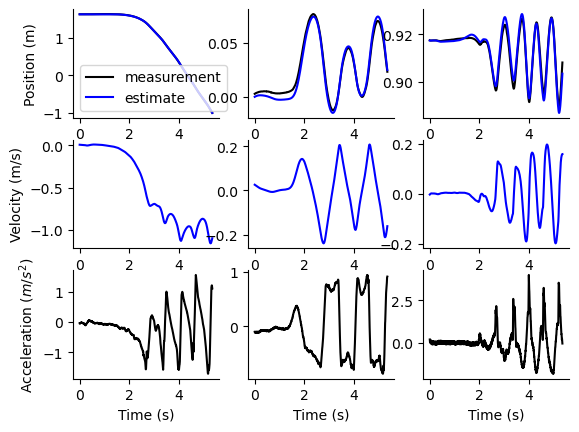

In [18]:
visualise(Acc_subsampled, Pos_subsampled, Pos_estimate, Vel_estimate, Frequency)

The function optimal_combination combines all these successive steps

In [19]:
def optimal_combination(GroundReactionForce, Force_frequency, Kinematic_com, Kinematic_frequency, mass,
    Force_std = 2, Position_std = 0.002, gravity_direction = numpy.array([0,0,-1]), sub_frequency = None, Initial_conditions = None, Final_conditions = None, initial_samples = 10):
    '''Combines the Center of Mass position obtained from kinematic measurements with Ground reaction force to estimate the Center of Mass position and velocity
    
    Parameters
    ----------
    GroundReactionForce: (NbOfDimensions,NbOfSamples1) numpy.ndarray
        Ground reaction force (in Newton)
    Force_frequency: int 
        Sampling frequency (in Hertz) of the Ground reaction force
    Kinematic_com: (NbOfDimensions,NbOfSamples2) numpy.ndarray
        Center of Mass position obtained from kinematic measurements (in m)
    Kinematic_frequency: int 
        Sampling frequency (in Hertz) of the kinematics
    mass: float 
        subject's mass (in kg)
    Force_std: float or (NbOfDimensions,) numpy.ndarray, optional
        Standard deviation of the error in Ground reaction force (in N) (can be provided for each dimension independently), default is 2 N
    Position_std: float or (NbOfDimensions,) numpy.ndarray, optional
        Standard deviation of the error in CoM position obtained from the kinematics (in m) (can be provided for each dimension independently), default is 0.002 m
    gravity_direction: (NbOfDimensions) numpy.ndarray, optional
        direction of the gravity vector used to subtract the subject's weight, default is numpy.array([0,0,-1])
    sub_frequency: int, optional 
        Desired sub-sampling frequency (in Hertz), default is None
    Initial_conditions: (NbOfDimensions,2) numpy.ndarray, optional
        Initial estimates of position (in m) and velocity (in m/s), used when the estimator is applied forwards in time (default is None).
        If None, the initial conditions are determined by a least-squares fit on the first few samples.
    Final_conditions: (NbOfDimensions,2) numpy.ndarray, optional
        Final estimates of position (in m) and velocity (in m/s), used when the estimator is applied backwards in time (default is None).
        If None, the final conditions are determined by a least-squares fit on the first few samples.
    initial_samples: int, optional
        Number of samples used to estimate initial and final position and velocity (default is 10)
    
    Returns
    -------
    Pos_estimate: (NbOfDimensions, NbOfSamples) numpy.ndarray
        Position estimate (in m)
    Vel_estimate: (NbOfDimensions, NbOfSamples) numpy.ndarray
        Velocity estimate (in m/s)
    Frequency: int 
        Sampling frequency of the position and velocity estimates
    '''
    
    
    # The CoM acceleration is calculated from the Ground reaction force and mass 
    Acceleration = com_acceleration(GroundReactionForce, mass, gravity_direction = gravity_direction)

    # Position and Acceleration are sub-sampled at a common frequency
    Acc_subsampled, Pos_subsampled, Frequency = subsample_two_signals(Acceleration, Force_frequency, Kinematic_com, Kinematic_frequency, sub_frequency = sub_frequency)
    
    # The optimal estimator gains at that Frequency are calculated
    l1, l2 = estimator_gains(Force_std, Position_std, Frequency, mass)
    
    ## The estimator is applied both forwards in time and backwards, and the forwards and backwards estimates are merged.
    Pos_estimate, Vel_estimate = estimator_backandforth(Acc_subsampled, Pos_subsampled, l1, l2, Frequency, Initial_conditions = Initial_conditions, Final_conditions = Final_conditions, initial_samples = initial_samples)
    
    return Pos_estimate, Vel_estimate, Frequency

In [20]:
Pos_estimate, Vel_estimate, Frequency = optimal_combination(GroundReactionForce, Force_frequency, Kinematic_com, Kinematic_frequency, mass)

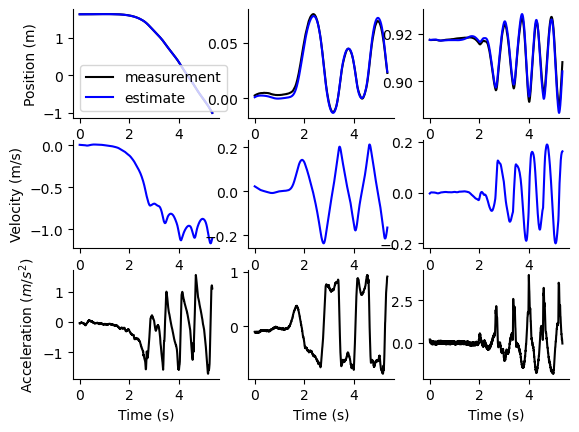

In [21]:
visualise(Acc_subsampled, Pos_subsampled, Pos_estimate, Vel_estimate, Frequency)